# Gas Station Optimization Problem
#### _Edward Krueger, edkrueger@gmail.com_

## Purpose

Learn how to modularize a simulation so that we can seach over different inputs to find an optimum.

## Overview

Now that you have completed Alice's simulation, she wants you to answer her over all question: "How many pumps should she have at her gas station?" She wants to know how many pumps are needed to maximize gallons sold.  In order to do this we will impove on the code from the Gas Station Simulation Problem. Feel free to use either your own code or the code in the solution as a starting point. 

## The details

### Encapsulate the Simulation

We need to rewrite the simulation as an encapsulated function that takes every variable the simulation needs to run as an argument. This will require that for every function or object, the parameters are passed explicitly as arguments; rather than being read as global variables.

This will allow us to easily see the effect of gas pumps on the number of gallons sold.

Tips:
* We can either eliminate the print statement of include a flag telling whether or not the simulation should print results. The simulation and optimization will run much faster if they don't have to print and the output will be much cleaner.
* Since we are only focused on the number of gallons sold, we don't need the other metrics. Since the GasStation instance keeps track of all of the gas sold, we don't need to save the Car instances in a list.

### Simulate for Different Numbers of Pumps

Now since we have a function that returns the simulated number of gallons sold, we can to run this function for a number of values to see its results. Make a correspondence between the number of pumps and the gallons sold.

### Find the Optimum using code

Since you have the correspondence you can simply find the optimum values by searching through it. There are many built in methods for this.

### Manually Inspect Correspondence and Plot it

You'll see that there are many near optimum points. Make an agrument about how many pumps Alice should install.

# Gas Station Optimization Solution

## Setup

In [1]:
import simpy

import numpy as np
import pandas as pd

from scipy.stats import expon
from scipy.stats import norm

import matplotlib.pyplot as plt

In [2]:
np.random.seed(seed=9000)

## Encapsulate the simulation

In [3]:
class GasStation():
    
    """
    Models a gas station as a simpy.Resource with a given number of pumps.
    
    Arguments:
    -----------
    num_pumps (int): The number of pumps at the gas station
    env (simpy.Environment): The simpy environment
    """
    
    def __init__(self, num_pumps, env):
        
        self.num_pumps = num_pumps
        
        self.env = env
        
        self.resource = simpy.Resource(self.env, capacity=num_pumps)
        
        self.minutes_utilized = 0
        self.gallons_sold = 0

In [4]:
class Car():

    """
    Models a car.
    The car's simulation process in the simulation is the method .run().
    
    Arguments:
    -----------
    id (int): A unique id for the car
    gas_required (float): Amount of gallons a car will fill
    lay_time (float): Extra minutes that the car stays at the pump
    gas_station (GasStation): The gas station the cars are going to
    env (simpy.Environment): The simpy environment
    
    """
    
    def __init__(
        self,
        id,
        gas_required,
        lay_time,
        gas_station,
        pump_rate,
        env,
        verbose
    ):
        
        self.id = id
        self.gas_required = gas_required
        self.lay_time = lay_time
        self.gas_station = gas_station
        self.pump_rate = pump_rate
        self.env = env
        
        self.verbose = verbose
        
        self.wait_time = np.inf
        self.finished = False
        
        self.action = self.env.process(self.run())
        
    def run(self):
        
        queue_time = self.env.now
        
        if self.verbose:
            print(f'Car {self.id} arrives at {round(queue_time, 2)} minutes')
                
        with self.gas_station.resource.request() as req:
            
            yield req
            
            pump_start_time = self.env.now
            
            if self.verbose:
                print(f'Car {self.id} begins utilizing a pump at {round(pump_start_time, 2)} minutes')

            pump_time = self.gas_required / self.pump_rate
            utilization = max(pump_time, self.lay_time)
            
            yield self.env.timeout(utilization)
            
            pump_end_time = self.env.now
            
            if self.verbose:
                print(f'Car {self.id} leaves its pump at {round(pump_end_time, 2)} minutes')
            
            self.finished = True
            
            self.wait_time = pump_start_time - queue_time
            self.gas_station.minutes_utilized += utilization
            self.gas_station.gallons_sold += self.gas_required

In [5]:
def scheduler(
    expected_wait,
    gas_required_mean,
    gas_required_std,
    pump_rate,
    expected_lay_time,
    gas_station,
    cars,
    env,
    verbose
):
    
    """
    Controls the arrival of cars at the gas station.
    
    Arguments:
    -----------
    env (simpy.Environment): The simpy environment
    """
    
    id = 0
    
    while True:
        
        waiting_time = expon.rvs(loc=0, scale=expected_wait)
        
        std_norm = norm.rvs()
        gas_required = std_norm * gas_required_std + gas_required_mean
        gas_required = max([0, gas_required])
        
        lay_time = expon.rvs(loc=0, scale=expected_lay_time)
        
        yield env.timeout(waiting_time)
        
        cars.append(
            Car(
                id=id,
                gas_required=gas_required,
                lay_time=lay_time,
                gas_station=gas_station,
                pump_rate = pump_rate,
                env=env,
                verbose=verbose
            )
        )
        
        id += 1

In [6]:
def sim(
    num_pumps,
    expected_wait,
    gas_required_mean,
    gas_required_std,
    pump_rate,
    expected_lay_time,
    sim_time,
    verbose = False
):
    
    env = simpy.Environment()
    cars = []
    gas_station = GasStation(num_pumps, env)
    env.process(
        scheduler(
            expected_wait,
            gas_required_mean,
            gas_required_std,
            pump_rate,
            expected_lay_time,
            gas_station,
            cars,
            env,
            verbose=verbose
        )
    )
    env.run(until=sim_time)
    
    total_gallons_sold = gas_station.gallons_sold
    
    return total_gallons_sold

## Create Fixed Parameters

In [7]:
fixed_parameters = {
    'expected_wait': 2,
    'gas_required_mean': 15,
    'gas_required_std': 5,
    'pump_rate': 10,
    'expected_lay_time': 5,
    'sim_time': 24 * 60,
}

## Do a test run of the simulation

In [8]:
gas_sold = sim(
    num_pumps=1,
    **fixed_parameters,
    verbose=True
)

gas_sold

Car 0 arrives at 0.69 minutes
Car 0 begins utilizing a pump at 0.69 minutes
Car 1 arrives at 0.79 minutes
Car 2 arrives at 1.64 minutes
Car 0 leaves its pump at 3.26 minutes
Car 1 begins utilizing a pump at 3.26 minutes
Car 3 arrives at 3.27 minutes
Car 4 arrives at 3.91 minutes
Car 5 arrives at 4.14 minutes
Car 6 arrives at 4.46 minutes
Car 7 arrives at 6.64 minutes
Car 1 leaves its pump at 10.99 minutes
Car 2 begins utilizing a pump at 10.99 minutes
Car 2 leaves its pump at 12.11 minutes
Car 3 begins utilizing a pump at 12.11 minutes
Car 8 arrives at 13.0 minutes
Car 9 arrives at 13.67 minutes
Car 10 arrives at 15.39 minutes
Car 11 arrives at 16.1 minutes
Car 12 arrives at 17.16 minutes
Car 3 leaves its pump at 18.56 minutes
Car 4 begins utilizing a pump at 18.56 minutes
Car 13 arrives at 20.4 minutes
Car 14 arrives at 21.64 minutes
Car 15 arrives at 23.38 minutes
Car 16 arrives at 25.39 minutes
Car 4 leaves its pump at 25.7 minutes
Car 5 begins utilizing a pump at 25.7 minutes
Car 1

Car 495 arrives at 974.44 minutes
Car 213 leaves its pump at 975.43 minutes
Car 214 begins utilizing a pump at 975.43 minutes
Car 496 arrives at 975.5 minutes
Car 497 arrives at 975.99 minutes
Car 214 leaves its pump at 978.28 minutes
Car 215 begins utilizing a pump at 978.28 minutes
Car 498 arrives at 983.66 minutes
Car 499 arrives at 990.72 minutes
Car 500 arrives at 990.76 minutes
Car 501 arrives at 993.83 minutes
Car 502 arrives at 995.88 minutes
Car 503 arrives at 996.02 minutes
Car 215 leaves its pump at 997.52 minutes
Car 216 begins utilizing a pump at 997.52 minutes
Car 504 arrives at 997.83 minutes
Car 505 arrives at 999.6 minutes
Car 216 leaves its pump at 1000.79 minutes
Car 217 begins utilizing a pump at 1000.79 minutes
Car 506 arrives at 1001.01 minutes
Car 507 arrives at 1001.44 minutes
Car 508 arrives at 1012.26 minutes
Car 509 arrives at 1012.67 minutes
Car 217 leaves its pump at 1012.96 minutes
Car 218 begins utilizing a pump at 1012.96 minutes
Car 510 arrives at 1017.

4477.33662801084

## Do the naive optimization

In [9]:
opt_table = pd.Series(
    {num_pumps: sim(num_pumps, **fixed_parameters) for num_pumps in range(1,16)}
)

### Automatically Find the Optimum

In [10]:
arg_max = opt_table.idxmax()
max_gallons_sold = opt_table[arg_max]

print(f'The maximum number of gallons sold is {max_gallons_sold} with {arg_max} pumps')

The maximum number of gallons sold is 11467.210757245826 with 14 pumps


### Manually inspect the correspondence

In [11]:
opt_table

1      4195.051873
2      8718.263152
3     10926.866327
4     11221.042366
5     10702.982118
6     10758.105185
7     10247.182174
8     11304.760622
9     11166.687784
10    11324.018813
11    11022.252169
12    10776.576862
13    10602.687018
14    11467.210757
15    10788.720555
dtype: float64

### Plot the correspondence

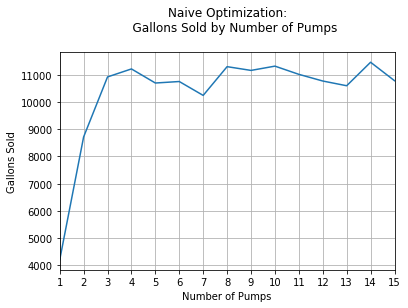

In [12]:
opt_table.plot(
    title=
    '''Naive Optimization:
    Gallons Sold by Number of Pumps
    ''',
    xticks=range(1, opt_table.shape[0] + 1),
    grid=True
)

plt.xlabel('Number of Pumps')
plt.ylabel('Gallons Sold')
plt.show()

Its hard to see what the sugestion to Alice should be from this graph. With these runs of the simulation, we got the maximum gallons solds at 14 pumps. However, since the draws in the simulation were by random chance, this could have just been by accident. 3 or 4 pumps seems like a more plausible recomendation because they are near optimal and, presumeably, pumps are not free. To demonstrate the randomness of the result I'll run the simulation again.

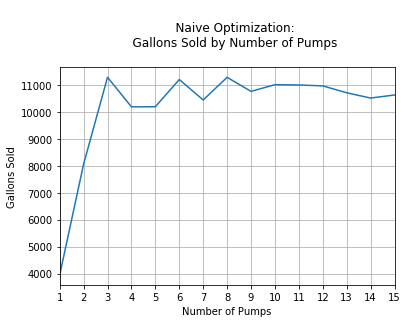

In [13]:
np.random.seed(seed=19000)

opt_table = pd.Series(
    {num_pumps: sim(num_pumps, **fixed_parameters) for num_pumps in range(1,16)}
)

opt_table.plot(
    title='''
    Naive Optimization:
    Gallons Sold by Number of Pumps
    ''',
    xticks=range(1, opt_table.shape[0] + 1),
    grid=True
)

plt.xlabel('Number of Pumps')
plt.ylabel('Gallons Sold')
plt.show()

## Do Robust Optimization with Monte Carlo Simulation

In [14]:
def monte_carlo_sim(func, num_pumps, n_iter, **kwargs):
    results = np.array([func(num_pumps, **kwargs) for _ in range(n_iter)])
    return {
        'num_pumps': num_pumps,
        'mean': np.mean(results),
        'std': np.std(results)
    }

### Do a test run of the Monte Carlo simulation

In [15]:
%%time
monte_carlo_sim(
    func=sim,
    num_pumps=4,
    n_iter=100,
    **fixed_parameters
)

CPU times: user 11.8 s, sys: 198 ms, total: 12 s
Wall time: 11.8 s


{'num_pumps': 4, 'mean': 10781.62298720108, 'std': 443.4059218529631}

## Do the Monte Carlo based optimization

In [16]:
%%time
mc_opt_table = pd.DataFrame([
    monte_carlo_sim(
        func=sim,
        num_pumps=n,
        n_iter=100,
        **fixed_parameters
    )
    for n in range(1,16)
])

CPU times: user 2min 53s, sys: 2.58 s, total: 2min 56s
Wall time: 2min 55s


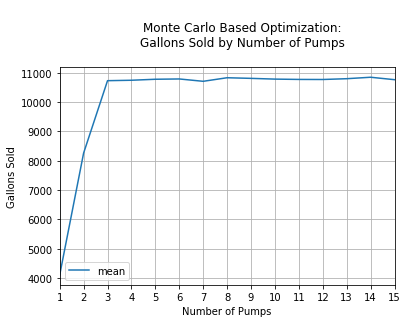

In [17]:
mc_opt_table\
    .set_index('num_pumps')\
    .drop('std', axis=1)\
    .plot(
        title='''
        Monte Carlo Based Optimization:
        Gallons Sold by Number of Pumps
        ''',
        xticks=range(1, mc_opt_table.shape[0] + 1),
        grid=True
    )


plt.xlabel('Number of Pumps')
plt.ylabel('Gallons Sold')
plt.show()